# Analyzing data run 5

* Particle: 100 nm gold 0.5 Hz, 3 V
* Recorded Framerate: 54.9661957895894
* This means that 1 oscillation happens in approximately **110 frames**

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, push_notebook
from bokeh.models import HoverTool, CustomJS, Slider, ColumnDataSource
from bokeh.layouts import row, column, gridplot
import trackpy as tp
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import label

output_notebook()
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(30, 15))
mpl.rc('image', cmap='gray')
mpl.rc('xtick', labelsize=24)
mpl.rc('ytick', labelsize=24)

Loading BokehJS ...

In [63]:
file_dir = '/home/aquiles/Documents/Data/Tracking/run100nm'
filename = 'data.h5'
with h5py.File(os.path.join(file_dir, filename)) as file:
    data = file['Basler data'][:,:,:]
frames = np.linspace(1, data.shape[0], data.shape[0])

## Quick insight into the data

First, let's calculate the total intensity, in order to check if something changed during the acquisition.

In [3]:
intensities = np.sum(np.sum(data[:,:,:],1),1)
hover = HoverTool(tooltips=[("Frame", "@x")])
p = figure()
p.add_tools(hover)
p.line(frames, intensities, line_width=1)
show(p)

There are some sharp steps in the intensity. Frame **717** is one of them

In [ ]:
p = figure(x_range=(1, 300), y_range=(1, 250))
hover = HoverTool(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")])
p.add_tools(hover)
img = np.squeeze(data[717, :, :])
source = ColumnDataSource(data=dict(image=[data[0, :, :]]))
p.image(image='image', x=1, y=1, dw=300, dh=250, source=source, palette="Spectral11")
s2 = figure()
s2.add_tools(hover)
s2.line(frames, intensities, line_width=2)
def update_image(frame):
    source.data = dict(image=[data[frame, :, :]])
    push_notebook(handle=bokeh_handle)  

callback = CustomJS(code="""
if (IPython.notebook.kernel !== undefined) {
    var kernel = IPython.notebook.kernel;
    cmd = "update_image(" + cb_obj.value + ")";
    kernel.execute(cmd, {}, {});
}
""")

slider = Slider(start=1, 
                end=2000,
                value=1,
                step=1,
                title="frame",
                callback=callback)
bokeh_handle = show(gridplot([p, slider], [s2, None]), notebook_handle=True)
output_file('test.html')

## Let's make a self-standing document with the data

In [ ]:
from bokeh.io import curdoc
from bokeh.layouts import layout

p = figure(x_range=(1, 300), y_range=(1, 250))
hover = HoverTool(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")])
p.add_tools(hover)
img = np.squeeze(data[717, :, :])
source = ColumnDataSource(data=dict(image=[data[0, :, :]]))
p.image(image='image', x=1, y=1, dw=300, dh=250, source=source, palette="Spectral11")
s2 = figure()
s2.add_tools(hover)
s2.line(frames, intensities, line_width=2)
   

def slider_callback(attr, old, new):
    source.data = dict(image=[data[new, :, :]])
    
slider.on_change('value', slider_callback)

slider = Slider(start=1, 
                end=2000,
                value=1,
                step=1,
                title="Frame")


lyt = layout([p, slider], [s2]) 
curdoc().add_root(lyt)
output_file('test.html')

In [ ]:
median_data = np.median(data, 0)
data_bkg = data - median_data
avg_data = np.sum(data[:100,:,:], 0)

In [ ]:
f = tp.locate(data[10, :,:], 7)
len(f)

In [ ]:
plt.figure()  # make a new figure
tp.annotate(f, data[10, : ,:]);

In [ ]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [ ]:
f = tp.locate(data[0, :,:], 9, minmass=250)
plt.figure()  # make a new figure
tp.annotate(f, data[0, : ,:]);

In [ ]:
plt.figure()
tp.subpx_bias(f);

In [ ]:
f = tp.batch(data[:], 9, minmass=250);

In [ ]:
t = tp.link_df(f, 5, memory=3)

In [ ]:
plt.figure()
tp.plot_traj(t);

In [ ]:
d = tp.compute_drift(t)
plt.figure()
d.plot()

In [ ]:
centers = tp.locate(data[0, :, :], 9, minmass=250)

In [ ]:
centers

In [ ]:
plt.imshow(data[1,:,:])

In [ ]:
bkg = np.median(data[1:100,:,:],0)
plt.imshow(bkg)

In [ ]:
mask = data[1,:,:]>np.mean(data[1,:,:])+np.std(data[1,:,:])

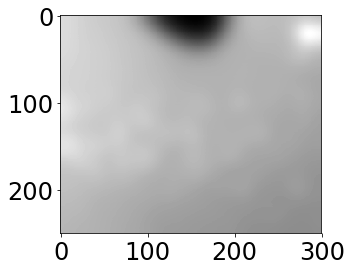

In [5]:
bkg = gaussian_filter(data[1,:,:], 10)
plt.imshow(bkg)

In [6]:
d = np.int16(data[0, :, :])
clear_data = np.clip(d-bkg,0,None)

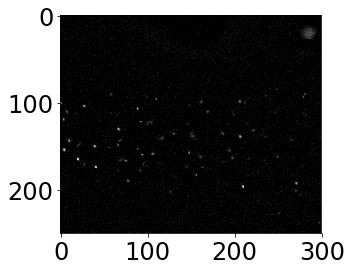

In [7]:
plt.imshow(clear_data)

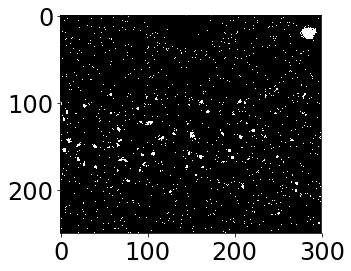

In [8]:
mask = clear_data>np.mean(clear_data)+np.std(clear_data)*2
plt.imshow(mask)

In [23]:
structure = \
[[0,0,0],
 [0,1,0],
 [0,0,0]]
result = label(mask, structure=structure)
print('Found {} elements'.format(result[1]))

Found 2131 elements


In [24]:
p = figure(x_range=(1, 300), y_range=(1, 250))
hover = HoverTool(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")])
p.add_tools(hover)
img = result[0]
source = ColumnDataSource(data=dict(image=[img]))
p.image(image='image', x=1, y=1, dw=300, dh=250, source=source, palette="Spectral11")
show(p)

In [25]:
from scipy.ndimage import find_objects
objects = find_objects(result[0])

In [42]:
for i in range(result[1]):
    number = np.count_nonzero(result[0]==i)
    if number<=4:
        

In [57]:
from scipy.ndimage import center_of_mass

In [58]:
com = center_of_mass(clear_data, result[0])

In [59]:
com

(123.15288919102652, 150.72595018849267)

In [62]:
clear_data.shape

(250, 300)